In [1]:
import numpy as np
import pandas as pd

In [60]:
import numpy as np
import requests
import unicodedata
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input
from tensorflow.keras.utils import to_categorical
import random

In [2]:
#Plotting
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure

In [3]:
#Regular expressions
import re

#Text processing
from unicodedata import normalize
import nltk
from nltk.corpus import stopwords

In [4]:
!pip install datasets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 6.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which 

In [5]:
#Huggingface
from transformers import Trainer
from transformers import AutoTokenizer
from transformers import pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from transformers.pipelines.pt_utils import KeyDataset
from datasets import Dataset
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments

In [6]:
#Pytorch and progress bar
import torch
from torch import nn
from tqdm.auto import tqdm

#Performance metric
from sklearn.metrics import f1_score

from os.path import exists

In [8]:
# 1. Leer el CSV con separador '|' y forzar motor Python
df = pd.read_csv(
    "/content/emociones.csv",
    sep="|", #The separator was incorrectly escaped
    engine="python",
    encoding="latin-1",      # lee con latin-1 para capturar bien los bytes
    header=None, #There was no header in the file, so we use header = None                # asume que la primera fila es cabecera
    names=["tweet", "emotion"]
)

# 2. Quitar espacios sobrantes
df["tweet"]   = df["tweet"].str.strip()
df["emotion"] = df["emotion"].str.strip()

In [9]:
df_emociones = pd.read_csv("emociones.csv", sep="|", encoding='utf-8')

# Filtrar el DataFrame para mostrar solo las filas donde la emoción es 'lonely'
df_emociones_lonely = df_emociones[df_emociones['emotion'] == 'lonely']

# Mostrar las primeras filas del DataFrame filtrado
df_emociones_lonely.head()

,tweet,emotion
6136,Acostarse en esta hamaca todos los domingos so...,lonely
6137,Mis hijas se fueron hasta el martes y nunca m...,lonely
6138,"54, viudo, amo mi trabajo/amigos/pueblo... Am...",lonely
6139,Me di cuenta de cómo la ansiedad por la separ...,lonely
6140,todavía no sé cómo sentirme hacia la carta de...,lonely


In [10]:
import nltk
nltk.download('stopwords')
def clean_text(text):
    text = text.lower()
    text = normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8')
    text = re.sub(r"@\w+|https?://\S+|[^a-zA-Z\s]", '', text)
    tokens = [w for w in text.split() if w not in stopwords.words('spanish')]
    return ' '.join(tokens)

# Aplicar limpieza:
df['processed_tweet'] = df['tweet'].astype(str).apply(clean_text)
print(df[['tweet','processed_tweet']].head())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


                                               tweet  \
0                                              tweet   
1  Solo soy un desastre caliente que estÃ¡ estres...   
2  Estoy tan aburrido de esta mierda de nuevo. Es...   
3  Me encantaban tus cosas viejas, pero esto, est...   
4  alguna vez se deprimen, porque la Ãºnica perso...   

                                     processed_tweet  
0                                              tweet  
1  solo desastre caliente estresada deprimida mal...  
2  tan aburrido mierda nuevo tan feliz haber supe...  
3  encantaban cosas viejas deprime gento amo herm...  
4  alguna vez deprimen aonica persona quieren hab...  


In [11]:
df.head()

,tweet,emotion,processed_tweet
0,tweet,emotion,tweet
1,Solo soy un desastre caliente que estÃ¡ estres...,depressed,solo desastre caliente estresada deprimida mal...
2,Estoy tan aburrido de esta mierda de nuevo. Es...,depressed,tan aburrido mierda nuevo tan feliz haber supe...
3,"Me encantaban tus cosas viejas, pero esto, est...",depressed,encantaban cosas viejas deprime gento amo herm...
4,"alguna vez se deprimen, porque la Ãºnica perso...",depressed,alguna vez deprimen aonica persona quieren hab...


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40807 entries, 0 to 40806
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   tweet            40807 non-null  object
 1   emotion          40807 non-null  object
 2   processed_tweet  40807 non-null  object
dtypes: object(3)
memory usage: 956.5+ KB


In [13]:
df['emotion'].value_counts()

,count
emotion,
neutral,6995
suicidal,6830
depressed,5949
lonely,5023
disappointment,4765
disgust,2289
fear,2235
anger,1388
sadness,1201


In [14]:
# Eliminar la fila incorrecta
df = df[df['emotion'] != 'emotion']

In [15]:
# Eliminar la fila incorrecta
df = df[df['emotion'] != 'emotion']

In [16]:
df['emotion'].value_counts()

,count
emotion,
neutral,6995
suicidal,6830
depressed,5949
lonely,5023
disappointment,4765
disgust,2289
fear,2235
anger,1388
sadness,1201


In [17]:
df['emotion'].unique()

array(['depressed', 'hopeless', 'lonely', 'suicidal', 'disappointment',
       'disgust', 'remorse', 'grief', 'embarrassment', 'fear',
       'nervousness', 'sadness', 'anger', 'neutral'], dtype=object)

In [18]:
df.emotion = pd.Categorical(df.emotion)
df['label'] = df.emotion.cat.codes

In [19]:
id2label = df[['emotion', 'label']].drop_duplicates(keep='first').sort_values(by='label').reset_index(drop=True)['emotion'].to_dict()
id2label

{0: 'anger',
 1: 'depressed',
 2: 'disappointment',
 3: 'disgust',
 4: 'embarrassment',
 5: 'fear',
 6: 'grief',
 7: 'hopeless',
 8: 'lonely',
 9: 'nervousness',
 10: 'neutral',
 11: 'remorse',
 12: 'sadness',
 13: 'suicidal'}

In [20]:
label2id = {v:k for k,v in id2label.items()}
label2id

{'anger': 0,
 'depressed': 1,
 'disappointment': 2,
 'disgust': 3,
 'embarrassment': 4,
 'fear': 5,
 'grief': 6,
 'hopeless': 7,
 'lonely': 8,
 'nervousness': 9,
 'neutral': 10,
 'remorse': 11,
 'sadness': 12,
 'suicidal': 13}

In [21]:
df.drop(df[df.tweet.isna() == True].index, inplace=True)
df.drop(columns='emotion', inplace=True)

df

,tweet,processed_tweet,label
1,Solo soy un desastre caliente que estÃ¡ estres...,solo desastre caliente estresada deprimida mal...,1
2,Estoy tan aburrido de esta mierda de nuevo. Es...,tan aburrido mierda nuevo tan feliz haber supe...,1
3,"Me encantaban tus cosas viejas, pero esto, est...",encantaban cosas viejas deprime gento amo herm...,1
4,"alguna vez se deprimen, porque la Ãºnica perso...",alguna vez deprimen aonica persona quieren hab...,1
5,"En realidad, liau es un signo de madurez, creo...",realidad liau signo madurez creo gusta owez qu...,1
...,...,...,...
40802,La gente le dice burro a otro y ni sabe escrib...,gente dice burro sabe escribir redes sociales,10
40803,"Â¡Dios MÃ­o ! Yo creo , adoro , espero y os am...",adios mao creo adoro espero amo pido perdan cr...,10
40804,En fotos : El hombre con el peor trabajo del m...,fotos hombre peor trabajo mundo turlurl,10
40805,Los chorros llamando a la policÃ­a para que lo...,chorros llamando policaa protejan vos seguas p...,10


In [22]:
train, validation, test = np.split(df.sample(frac=1), [int(.6*len(df)), int(.8*len(df))])

/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [23]:
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)
validation.reset_index(drop=True, inplace=True)

In [24]:
train.to_csv('train.csv', sep='|', index=False)
validation.to_csv('validation.csv', sep='|', index=False)
test.to_csv('test.csv', sep='|', index=False)

In [25]:
#train = pd.read_csv('train.csv', sep='|')
#validation = pd.read_csv('validation.csv', sep='|')
#test = pd.read_csv('test.csv', sep='|')

train = train[train['tweet'].map(len) <= 280]
validation = validation[validation['tweet'].map(len) <= 280]
test = test[test['tweet'].map(len) <= 280]

In [26]:
train.label.value_counts()

,count
label,
10,4165
1,3000
2,2879
13,2759
8,2654
3,1395
5,1271
0,678
4,662


In [27]:
validation.label.value_counts()

,count
label,
10,1417
1,983
13,938
2,916
8,888
3,444
5,426
0,250
4,210


In [28]:
test.label.value_counts()

,count
label,
10,1410
13,994
2,970
1,963
8,896
3,450
5,429
0,230
4,222


In [29]:
train_dataset = Dataset.from_pandas(train)
validation_dataset = Dataset.from_pandas(validation)

In [30]:
model_ckpt='pysentimiento/robertuito-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/323 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/858k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

In [31]:
def tokenize_tweets(tweet):
    return tokenizer(tweet['tweet'], truncation=True, max_length=64)

In [32]:
train_dataset = train_dataset.map(tokenize_tweets, batched=True)
train_dataset

Map:   0%|          | 0/21729 [00:00<?, ? examples/s]

Dataset({
    features: ['tweet', 'processed_tweet', 'label', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 21729
})

In [33]:
validation_dataset = validation_dataset.map(tokenize_tweets, batched=True)
validation_dataset

Map:   0%|          | 0/7196 [00:00<?, ? examples/s]

Dataset({
    features: ['tweet', 'processed_tweet', 'label', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 7196
})

In [34]:
class_weights = (1 - (train['label'].value_counts().sort_index() /len(train))).values

class_weights = torch.from_numpy(class_weights).float().to("cuda")

In [37]:
class_weights

tensor([0.9688, 0.8619, 0.8675, 0.9358, 0.9695, 0.9415, 0.9908, 0.9760, 0.8779,
        0.9831, 0.8083, 0.9731, 0.9727, 0.8730], device='cuda:0')

In [38]:
torch.cuda.is_available()

True

In [39]:
train_dataset = train_dataset.rename_column("label", "labels")
validation_dataset = validation_dataset.rename_column("label", "labels")

train_dataset = train_dataset.rename_column("tweet", "text")
validation_dataset = validation_dataset.rename_column("tweet", "text")

In [40]:
#Loss function
class WheightedLossTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        outputs = model(**inputs)
        logits = outputs.get("logits")
        labels = inputs.get("labels")
        loss_func = nn.CrossEntropyLoss(weight=class_weights)
        loss = loss_func(logits, labels)

        return (loss, outputs) if return_outputs else loss

In [41]:
num_labels = len(id2label)
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels, id2label=id2label, label2id=label2id)

config.json:   0%|          | 0.00/677 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/435M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at pysentimiento/robertuito-base-uncased and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [42]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    return {"f1": f1}

In [43]:
#Training Arguments
batch_size = 16
logging_steps = len(train_dataset)
output_dir = "finetuned-emotion"

steps_per_epoch = int(len(train_dataset) / batch_size)

training_args = TrainingArguments(output_dir=output_dir,
                                  num_train_epochs=2,
                                  learning_rate=5e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  eval_steps=steps_per_epoch,
                                  logging_steps=logging_steps,
                                  fp16=True,
                                  )

In [44]:
trainer = WheightedLossTrainer(model=model,
                               args=training_args,
                               compute_metrics=compute_metrics,
                               train_dataset=train_dataset,
                               eval_dataset=validation_dataset,
                               tokenizer=tokenizer)

<ipython-input-44-e55390355849>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WheightedLossTrainer.__init__`. Use `processing_class` instead.
  trainer = WheightedLossTrainer(model=model,


In [45]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: kquintero871 (kquintero871-quiero-ser-unab) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss


TrainOutput(global_step=2718, training_loss=0.5966019002368469, metrics={'train_runtime': 907.4561, 'train_samples_per_second': 47.89, 'train_steps_per_second': 2.995, 'total_flos': 1373462799282756.0, 'train_loss': 0.5966019002368469, 'epoch': 2.0})

In [46]:
trainer.evaluate()

{'eval_loss': 0.5723329186439514,
 'eval_f1': 0.8153883385084731,
 'eval_runtime': 7.5186,
 'eval_samples_per_second': 957.093,
 'eval_steps_per_second': 59.852,
 'epoch': 2.0}

In [47]:
trainer.save_model(model_ckpt + '-save')
tokenizer.save_pretrained(model_ckpt + '-save')

('pysentimiento/robertuito-base-uncased-save/tokenizer_config.json',
 'pysentimiento/robertuito-base-uncased-save/special_tokens_map.json',
 'pysentimiento/robertuito-base-uncased-save/tokenizer.json')

In [48]:
!zip -r /content/pysentimiento.zip /content/pysentimiento

  adding: content/pysentimiento/ (stored 0%)
  adding: content/pysentimiento/robertuito-base-uncased-save/ (stored 0%)
  adding: content/pysentimiento/robertuito-base-uncased-save/special_tokens_map.json (deflated 86%)
  adding: content/pysentimiento/robertuito-base-uncased-save/tokenizer_config.json (deflated 75%)
  adding: content/pysentimiento/robertuito-base-uncased-save/training_args.bin (deflated 51%)
  adding: content/pysentimiento/robertuito-base-uncased-save/config.json (deflated 57%)
  adding: content/pysentimiento/robertuito-base-uncased-save/tokenizer.json (deflated 83%)
  adding: content/pysentimiento/robertuito-base-uncased-save/model.safetensors (deflated 7%)


In [49]:
def predictEmotion(data, model):
    pipe = pipeline("text-classification", model=model,)
    test = pd.read_csv(data, sep="|")
    test_dataset = Dataset.from_pandas(test)

    predictedLabel = []
    for prediction in tqdm(pipe(KeyDataset(test_dataset, "tweet"))):
        predictedLabel.append(label2id.get(prediction.get('label')))

    test['predicted_label'] = predictedLabel

    return test

In [50]:
def saveClassificationReport(imgName, y_true, y_pred, labels):
    clf_report = classification_report(y_true, y_pred, target_names=labels, output_dict=True)
    clf_report = pd.DataFrame(clf_report).iloc[:-1, :].transpose()
    clf_report_macro = clf_report[14:]
    clf_report = clf_report[0:14].sort_values(by=['f1-score'], ascending=False)
    clf_report= pd.concat([clf_report, clf_report_macro])
    ax = sns.heatmap(clf_report, annot=True)
    ax.xaxis.tick_top() # x axis on top
    plt.title("classification_report_" + imgName,  fontsize=18, pad=20 )
    plt.savefig(imgName + '_clf', bbox_inches='tight')

    return clf_report

In [51]:
def printMacroF1(y_true, y_pred):
    f1 = f1_score(y_true, y_pred, average=None)
    i = 0
    for label in label2id:
        print(label, ": ", round(f1[i], 2))
        i+=1

In [52]:
imgName = 'RuPERTa-base'
data = 'test.csv'
modelSaved = '/content/pysentimiento/robertuito-base-uncased-save'

In [53]:
def saveConfusionMatrix(y_true, y_pred):
    fig, ax = plt.subplots(figsize=(10, 10))
    labels = list(label2id)
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp = disp.plot(xticks_rotation=-45, ax=ax)
    plt.title(imgName,  fontsize=18, pad=20)
    plt.savefig(imgName, bbox_inches='tight')

In [54]:
tokens = tokenizer(data[:5], padding=True, truncation=True, max_length=64, return_tensors="pt")
print(tokens)

{'input_ids': tensor([[   0, 4217, 1676,    2]]), 'token_type_ids': tensor([[0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1]])}


In [55]:
from transformers import pipeline
from datasets import Dataset
from tqdm import tqdm
import pandas as pd

def predictEmotion(data, model):
    pipe = pipeline(
        "text-classification",
        model=model,
        tokenizer=model,
        device=-1  # -1 para CPU, 0 para GPU
    )

    test = pd.read_csv(data, sep="|")
    test_dataset = Dataset.from_pandas(test)

    predictedLabel = []
    for prediction in tqdm(
        pipe(
            KeyDataset(test_dataset, "tweet"),
            batch_size=16,
            truncation=True,
            padding=True,
            max_length=64
        )
    ):
        predictedLabel.append(label2id.get(prediction.get('label')))

    test['predicted_label'] = predictedLabel

    return test


Device set to use cpu
8162it [14:46,  9.21it/s]


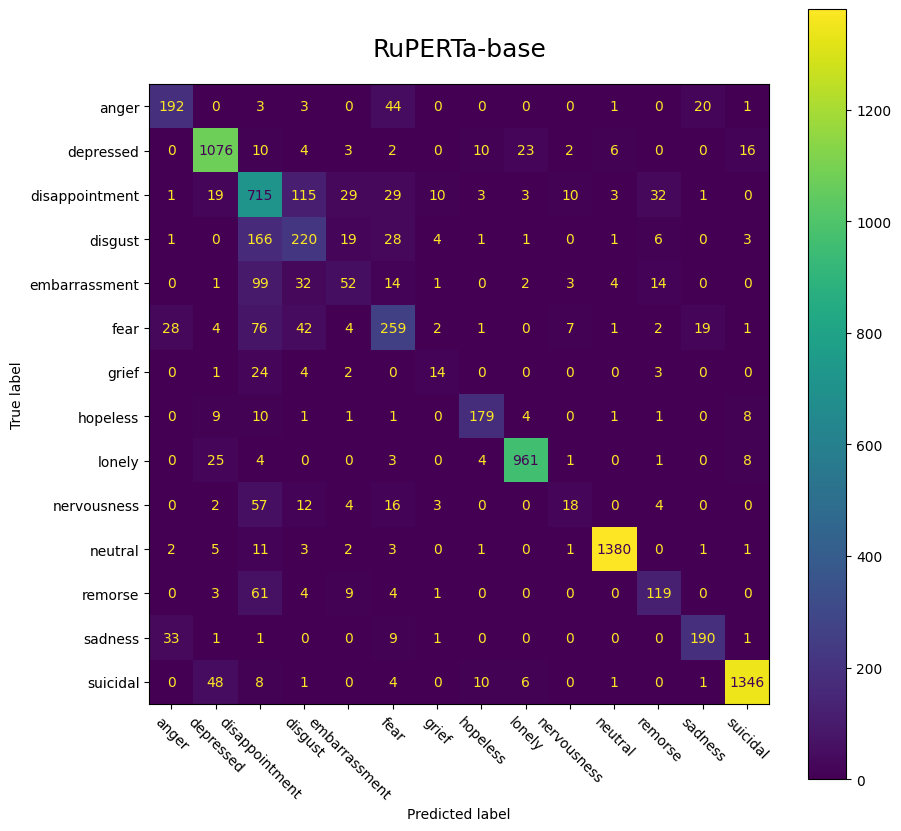

In [56]:
test = predictEmotion(data, modelSaved )

y_true = test['label']
y_pred = test['predicted_label']
labels = list(label2id)

saveConfusionMatrix(y_true, y_pred)

,precision,recall,f1-score
neutral,0.987124,0.978723,0.982906
suicidal,0.971841,0.944561,0.958007
lonely,0.961000,0.954320,0.957648
depressed,0.901173,0.934028,0.917306
hopeless,0.856459,0.832558,0.844340
sadness,0.818966,0.805085,0.811966
anger,0.747082,0.727273,0.737044
disappointment,0.574297,0.737113,0.645598
remorse,0.653846,0.592040,0.621410
fear,0.622596,0.580717,0.600928


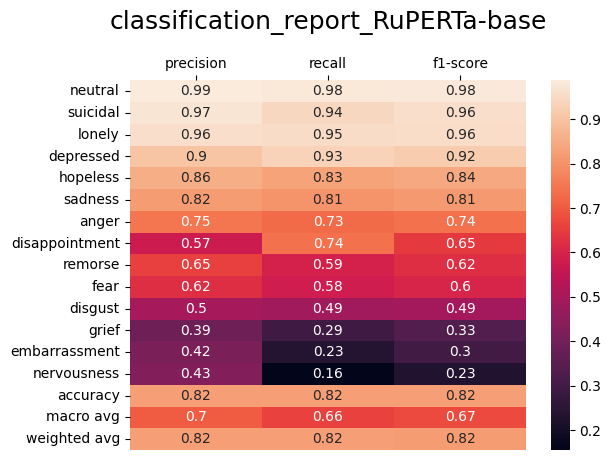

In [57]:
saveClassificationReport(imgName, y_true, y_pred, labels)

In [58]:
df

,tweet,processed_tweet,label
1,Solo soy un desastre caliente que estÃ¡ estres...,solo desastre caliente estresada deprimida mal...,1
2,Estoy tan aburrido de esta mierda de nuevo. Es...,tan aburrido mierda nuevo tan feliz haber supe...,1
3,"Me encantaban tus cosas viejas, pero esto, est...",encantaban cosas viejas deprime gento amo herm...,1
4,"alguna vez se deprimen, porque la Ãºnica perso...",alguna vez deprimen aonica persona quieren hab...,1
5,"En realidad, liau es un signo de madurez, creo...",realidad liau signo madurez creo gusta owez qu...,1
...,...,...,...
40802,La gente le dice burro a otro y ni sabe escrib...,gente dice burro sabe escribir redes sociales,10
40803,"Â¡Dios MÃ­o ! Yo creo , adoro , espero y os am...",adios mao creo adoro espero amo pido perdan cr...,10
40804,En fotos : El hombre con el peor trabajo del m...,fotos hombre peor trabajo mundo turlurl,10
40805,Los chorros llamando a la policÃ­a para que lo...,chorros llamando policaa protejan vos seguas p...,10
